In [1]:

!pip install /kaggle/input/pymupdf/*.whl --no-index --find-links=pymupdf-wheels

# 验证安装
try:
    import fitz
    print("PyMuPDF安装成功，版本:", fitz.__version__)
except ImportError as e:
    print("安装失败:", str(e))

Looking in links: pymupdf-wheels
Processing /kaggle/input/pymupdf/pymupdf-1.26.0-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
PyMuPDF安装成功，版本: 1.26.0


2025-07-31 02:10:24.365076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753927824.566592      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753927824.628158      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Loading training labels...
Loaded 1066 training labels
Primary: 270
Secondary: 449
Label distribution: Primary=270 (25.33%), Secondary=449 (42.12%)

Building file path mapping...
Found 523 valid training files
Processing 523 training files (sample size: 523)

Using lightweight method to extract text in parallel...

Building training dataset...
Collected 471 training contexts

Dataset Identifier Type Distribution:
  Unknown: 292 (62.00%)
  GenBank: 49 (10.40%)
  PDB: 48 (10.19%)
  ArrayExpress: 37 (7.86%)
  CHEMBL: 29 (6.16%)
  UniProt: 13 (2.76%)
  GEO: 3 (0.64%)

Training classification model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/scibert_scivocab_uncased/keras/default/1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


/tmp/ipykernel_19/4268396487.py:442: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall,F1 Primary,F1 Secondary
1,No log,0.148042,0.871646,0.926316,0.957317,0.825000,0.787879,0.955414
2,No log,0.061486,0.967105,0.978947,0.987013,0.950000,0.947368,0.986842


/tmp/ipykernel_19/4268396487.py:442: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}



Performing Detailed Model Evaluation

Detailed Model Performance Evaluation


/tmp/ipykernel_19/4268396487.py:442: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_19/4268396487.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() if k != 'labels'}



Classification Report:
              precision    recall  f1-score   support

   Secondary       0.97      1.00      0.99        75
     Primary       1.00      0.90      0.95        20

    accuracy                           0.98        95
   macro avg       0.99      0.95      0.97        95
weighted avg       0.98      0.98      0.98        95


Confusion Matrix:
                Predicted Secondary  Predicted Primary
Actual Secondary     75             0
Actual Primary       2             18

Validation set label distribution: Secondary=75, Primary=20 (21.05% Primary)
Prediction distribution: Secondary=77, Primary=18 (18.95% Primary)

Prediction Confidence Analysis:
Average confidence for correctly predicted Primary: 0.8754
Standard deviation of confidence for correctly predicted Primary: 0.2498
Average confidence for correctly predicted Secondary: 0.9938
Standard deviation of confidence for correctly predicted Secondary: 0.0086

Error Analysis:
False Positives (Secondary misclassi

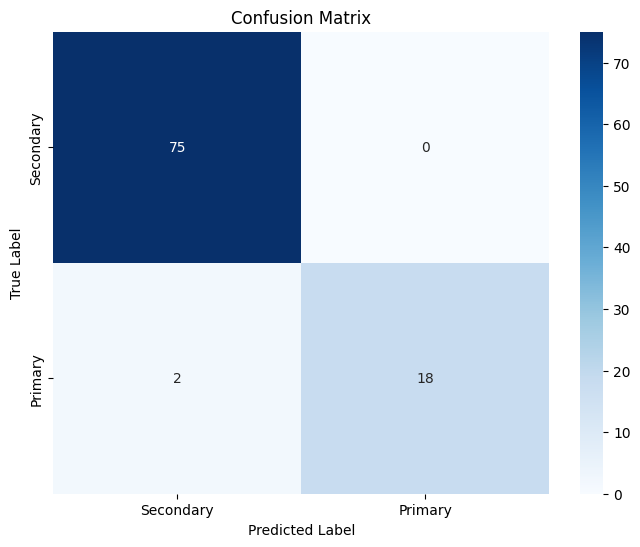

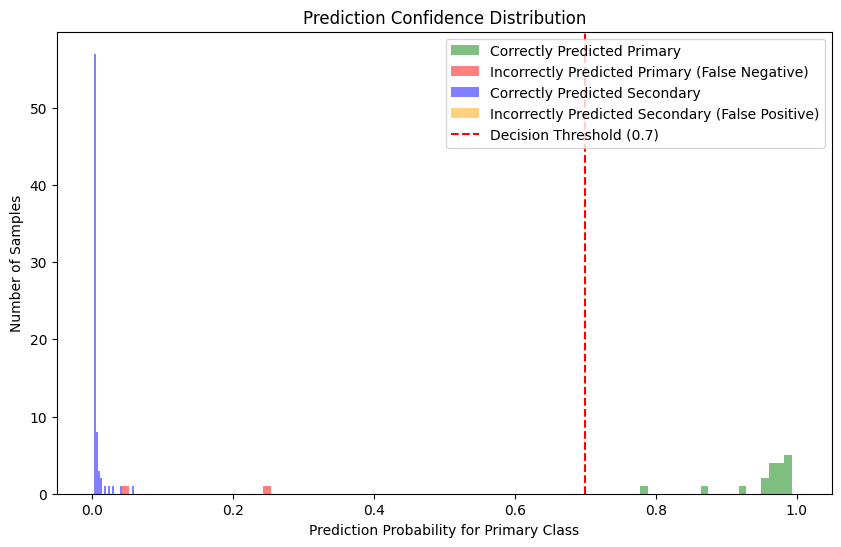

In [2]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import re
import time
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import concurrent.futures
import multiprocessing
import fitz  # PyMuPDF
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ------------------------------
# Configuration
# ------------------------------
SEED = 42
MODEL_NAME = "/kaggle/input/scibert_scivocab_uncased/keras/default/1"
MAX_LENGTH = 256
BATCH_SIZE = 16
THRESHOLD = 0.7
# Optimization: use fewer CPU cores to avoid overload
NUM_WORKERS = max(1, min(multiprocessing.cpu_count() - 2, 4))  # Limit to at most 4 processes

# Data paths
DATA_DIR = Path("/kaggle/input/make-data-count-finding-data-references")
TRAIN_XML_DIR = DATA_DIR / "train" / "XML"
TRAIN_PDF_DIR = DATA_DIR / "train" / "PDF"
TEST_XML_DIR = DATA_DIR / "test" / "XML"
TEST_PDF_DIR = DATA_DIR / "test" / "PDF"
TRAIN_LABELS_PATH = DATA_DIR / "train_labels.csv"

# Repository patterns
REPO_PATTERNS = {
    'GEO': r'\bGSE\d{4,}\b',
    'PDB': r'\b(?:PDB\s?)?\d[0-9A-Za-z]{3}\b',
    'ArrayExpress': r'\bE-[A-Z]{4}-\d{1,}\b',
    'CHEMBL': r'\bCHEMBL\d+\b',
    'EMBL': r'\bE-[A-Z]{3}-\d+\b',
    'UniProt': r'\b[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2}\b',
    'GenBank': r'\b[A-Z]{1,2}\d{5,8}(?:\.\d+)?\b'
}

# Ensure environment variable is set
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ------------------------------
# Text Extraction Functions
# ------------------------------
def extract_text_from_pdf_light(file_path, max_pages=20):
    """Ultra-fast PDF text extraction - optimized for scenarios where images are not needed"""
    try:
        doc = fitz.open(file_path)
        text_parts = []
        for page_num in range(min(max_pages, len(doc))):
            page = doc.load_page(page_num)
            text = page.get_text("text")  
            if text:
                text_parts.append(text)
        doc.close()
        text = " ".join(text_parts)
        # Simple cleaning
        text = re.sub(r'\s+', ' ', text)
        return text
    except Exception as e:
        print(f"Error processing PDF {file_path.name}: {str(e)}")
        return ""

def extract_text_from_xml_light(file_path):
    """Efficient XML text extraction"""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            soup = BeautifulSoup(f, 'lxml-xml')
            return re.sub(r'\s+', ' ', soup.get_text(separator=' ', strip=True))
    except Exception as e:
        print(f"Error processing XML {file_path.name}: {str(e)}")
        return ""

def extract_text_light(file_path):
    """Lightweight text extraction entry function"""
    if file_path.suffix.lower() == '.xml':
        return extract_text_from_xml_light(file_path)
    elif file_path.suffix.lower() == '.pdf':
        return extract_text_from_pdf_light(file_path)
    return ""

def batch_extract_text_light(file_paths, max_workers=None):
    """Batch parallel text extraction (lightweight version)"""
    if max_workers is None:
        max_workers = min(NUM_WORKERS, len(file_paths))
    results = {}
    if len(file_paths) <= 5 or max_workers == 1:
        for file_path in file_paths:
            results[file_path] = extract_text_light(file_path)
        return results

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_path = {
            executor.submit(extract_text_light, path): path 
            for path in file_paths
        }
        for future in concurrent.futures.as_completed(future_to_path):
            path = future_to_path[future]
            try:
                results[path] = future.result()
            except Exception as e:
                print(f"Error processing {path.name}: {str(e)}")
                results[path] = ""
    return results

# ------------------------------
# Identifier and Context Processing
# ------------------------------
def normalize_doi(doi):
    """Normalize DOI format"""
    doi = re.sub(r'^https?://(doi\.org/|dx\.doi\.org/)', '', doi, flags=re.IGNORECASE)
    doi = re.sub(r'^doi:', '', doi, flags=re.IGNORECASE)
    doi = re.sub(r'[^\w/.-]+$', '', doi.strip())
    return f"https://doi.org/{doi}" if doi.startswith('10.') else doi.upper()

def find_identifiers(text):
    """Find dataset identifiers"""
    if not text or len(text) < 10:
        return []
    results = set()
    # DOI extraction
    dois = re.findall(r'\b10\.\d{4,9}/[-._;()/:A-Z0-9]+\b', text, re.IGNORECASE)
    results.update(normalize_doi(doi) for doi in dois)
    # Repository-specific patterns
    for repo, pattern in REPO_PATTERNS.items():
        matches = re.findall(pattern, text)
        results.update(match.upper() if repo in ['GEO', 'PDB', 'CHEMBL'] else match for match in matches)
    return list(results)

def extract_context(text, identifier, window=150):
    """Extract context"""
    if not text or len(text) < len(identifier) + 20:
        return ""
    try:
        identifier_escaped = re.escape(identifier)
        pattern = fr'\b{identifier_escaped}\b'
        match = re.search(pattern, text)
        if match:
            start = max(0, match.start() - window)
            end = min(len(text), match.end() + window)
            return re.sub(r'\s+', ' ', text[start:end])  # Replace all whitespace characters using regex
    except Exception as e:
        print(f"Error extracting context: {str(e)}")
    return ""

# ------------------------------
# Evaluation Metrics Functions (Extended Version)
# ------------------------------
def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics for selecting the best model.
    Args:
        eval_pred: tuple (logits, labels)
    Returns:
        Dictionary containing multiple evaluation metrics.
    """
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)  # Convert logits to predicted classes
    # Compute multiple metrics
    f1 = f1_score(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    # F1 score for each class
    f1_per_class = f1_score(labels, preds, average=None)
    # Construct return results
    metrics = {
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_primary': float(f1_per_class[1]) if len(f1_per_class) > 1 else 0.0,
        'f1_secondary': float(f1_per_class[0]) if len(f1_per_class) > 0 else 0.0
    }
    return metrics

def evaluate_model_performance(model, eval_dataset, tokenizer, device):
    """
    Perform detailed evaluation of the model and generate a visual report
    """
    print("\n" + "="*50)
    print("Detailed Model Performance Evaluation")
    print("="*50)
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    # Prepare evaluation data
    all_preds = []
    all_labels = []
    all_probs = []
    # Process evaluation data in batches
    for i in range(0, len(eval_dataset), BATCH_SIZE):
        batch = eval_dataset[i:i+BATCH_SIZE]
        inputs = {k: torch.tensor(v).to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].numpy()
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Only take probability for "Primary" class
    # Compute various metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Secondary', 'Primary'], zero_division=0))
    # Print confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(f"                Predicted Secondary  Predicted Primary")
    print(f"Actual Secondary     {cm[0,0]}             {cm[0,1]}")
    print(f"Actual Primary       {cm[1,0]}             {cm[1,1]}")
    # Compute and print class distribution
    label_counts = Counter(all_labels)
    pred_counts = Counter(all_preds)
    print(f"\nValidation set label distribution: Secondary={label_counts[0]}, Primary={label_counts[1]} ({label_counts[1]/len(all_labels):.2%} Primary)")
    print(f"Prediction distribution: Secondary={pred_counts[0]}, Primary={pred_counts[1]} ({pred_counts[1]/len(all_preds):.2%} Primary)")
    # Analyze prediction confidence
    primary_probs = [p for i, p in enumerate(all_probs) if all_labels[i] == 1]
    secondary_probs = [p for i, p in enumerate(all_probs) if all_labels[i] == 0]
    print("\nPrediction Confidence Analysis:")
    if primary_probs:
        print(f"Average confidence for correctly predicted Primary: {np.mean(primary_probs):.4f}")
        print(f"Standard deviation of confidence for correctly predicted Primary: {np.std(primary_probs):.4f}")
    if secondary_probs:
        print(f"Average confidence for correctly predicted Secondary: {1 - np.mean(secondary_probs):.4f}")
        print(f"Standard deviation of confidence for correctly predicted Secondary: {np.std([1-p for p in secondary_probs]):.4f}")
    # Error analysis
    false_positives = [(i, all_probs[i]) for i in range(len(all_preds)) if all_preds[i] == 1 and all_labels[i] == 0]
    false_negatives = [(i, all_probs[i]) for i in range(len(all_preds)) if all_preds[i] == 0 and all_labels[i] == 1]
    print(f"\nError Analysis:")
    print(f"False Positives (Secondary misclassified as Primary): {len(false_positives)} samples")
    print(f"False Negatives (Primary misclassified as Secondary): {len(false_negatives)} samples")
    if false_positives:
        print("\nFalse Positive Confidence Statistics:")
        fp_probs = [p for _, p in false_positives]
        print(f"  Average confidence: {np.mean(fp_probs):.4f}")
        print(f"  Confidence range: [{min(fp_probs):.4f}, {max(fp_probs):.4f}]")
    if false_negatives:
        print("\nFalse Negative Confidence Statistics:")
        fn_probs = [p for _, p in false_negatives]
        print(f"  Average confidence: {np.mean(fn_probs):.4f}")
        print(f"  Confidence range: [{min(fn_probs):.4f}, {max(fn_probs):.4f}]")
    # Save evaluation report
    report_path = "./results/evaluation_report.txt"
    with open(report_path, "w") as f:
        f.write("Model Performance Evaluation Report\n")
        f.write("="*50 + "\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")
        f.write("Classification Report:\n")
        f.write(classification_report(all_labels, all_preds, target_names=['Secondary', 'Primary'], zero_division=0))
        f.write("\nConfusion Matrix:\n")
        f.write(f"                Predicted Secondary  Predicted Primary\n")
        f.write(f"Actual Secondary     {cm[0,0]}             {cm[0,1]}\n")
        f.write(f"Actual Primary       {cm[1,0]}             {cm[1,1]}\n")
        f.write(f"\nValidation set label distribution: Secondary={label_counts[0]}, Primary={label_counts[1]} ({label_counts[1]/len(all_labels):.2%} Primary)\n")
        f.write(f"Prediction distribution: Secondary={pred_counts[0]}, Primary={pred_counts[1]} ({pred_counts[1]/len(all_preds):.2%} Primary)\n")
    print(f"\nDetailed evaluation report saved to: {report_path}")
    # Generate confusion matrix visualization
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Secondary', 'Primary'],
                   yticklabels=['Secondary', 'Primary'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.savefig('./results/confusion_matrix.png')
        print("Confusion matrix visualization saved to: ./results/confusion_matrix.png")
    except Exception as e:
        print(f"Error generating confusion matrix visualization: {str(e)}")
    # Generate confidence distribution plot
    try:
        plt.figure(figsize=(10, 6))
        if primary_probs:
            plt.hist([p for i, p in enumerate(all_probs) if all_labels[i] == 1 and all_preds[i] == 1], 
                    bins=20, alpha=0.5, label='Correctly Predicted Primary', color='green')
            plt.hist([p for i, p in enumerate(all_probs) if all_labels[i] == 1 and all_preds[i] == 0], 
                    bins=20, alpha=0.5, label='Incorrectly Predicted Primary (False Negative)', color='red')
        if secondary_probs:
            plt.hist([p for i, p in enumerate(all_probs) if all_labels[i] == 0 and all_preds[i] == 0], 
                    bins=20, alpha=0.5, label='Correctly Predicted Secondary', color='blue')
            plt.hist([p for i, p in enumerate(all_probs) if all_labels[i] == 0 and all_preds[i] == 1], 
                    bins=20, alpha=0.5, label='Incorrectly Predicted Secondary (False Positive)', color='orange')
        plt.axvline(x=THRESHOLD, color='r', linestyle='--', label=f'Decision Threshold ({THRESHOLD})')
        plt.xlabel('Prediction Probability for Primary Class')
        plt.ylabel('Number of Samples')
        plt.title('Prediction Confidence Distribution')
        plt.legend()
        plt.savefig('./results/confidence_distribution.png')
        print("Confidence distribution plot saved to: ./results/confidence_distribution.png")
    except Exception as e:
        print(f"Error generating confidence distribution plot: {str(e)}")
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'label_distribution': {'Secondary': label_counts[0], 'Primary': label_counts[1]},
        'prediction_distribution': {'Secondary': pred_counts[0], 'Primary': pred_counts[1]},
        'false_positives': len(false_positives),
        'false_negatives': len(false_negatives)
    }

# ------------------------------
# Main Function
# ------------------------------
def main():
    """Main function"""
    start_time = time.time()
    # Check if required directories exist
    required_dirs = [
        TRAIN_XML_DIR,
        TRAIN_PDF_DIR,
        TEST_XML_DIR,
        TEST_PDF_DIR
    ]
    missing_dirs = [d for d in required_dirs if not d.exists()]
    if missing_dirs:
        print("Error: The following required directories do not exist:")
        for d in missing_dirs:
            print(f"  - {d}")
        print("Please ensure the data is properly downloaded and extracted to the current directory.")
        return
    # Load training labels
    print("\nLoading training labels...")
    if not TRAIN_LABELS_PATH.exists():
        print(f"Error: Training labels file {TRAIN_LABELS_PATH} does not exist")
        return
    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    print(f"Loaded {len(train_labels)} training labels")
    print(f"Primary: {len(train_labels[train_labels.type == 'Primary'])}")
    print(f"Secondary: {len(train_labels[train_labels.type == 'Secondary'])}")
    # Analyze label distribution
    primary_count = len(train_labels[train_labels.type == 'Primary'])
    secondary_count = len(train_labels[train_labels.type == 'Secondary'])
    print(f"Label distribution: Primary={primary_count} ({primary_count/len(train_labels):.2%}), Secondary={secondary_count} ({secondary_count/len(train_labels):.2%})")
    # Build file path mapping
    print("\nBuilding file path mapping...")
    all_train_files = {}
    for file_path in TRAIN_XML_DIR.glob('*.xml'):
        all_train_files[file_path.stem] = file_path
    for file_path in TRAIN_PDF_DIR.glob('*.pdf'):
        if file_path.stem not in all_train_files:
            all_train_files[file_path.stem] = file_path
    # Only process files present in training labels
    valid_train_files = {
        article_id: path for article_id, path in all_train_files.items() 
        if article_id in train_labels['article_id'].values
    }
    print(f"Found {len(valid_train_files)} valid training files")
    # Sampling
    n_samples = min(5000, len(valid_train_files))
    sample_files = list(valid_train_files.items())[:n_samples]
    file_paths = [path for _, path in sample_files]
    print(f"Processing {len(file_paths)} training files (sample size: {n_samples})")
    # Parallel text extraction (lightweight)
    print("\nUsing lightweight method to extract text in parallel...")
    text_results = batch_extract_text_light(file_paths)
    # Build training dataset
    print("\nBuilding training dataset...")
    contexts = []
    labels = []
    repo_types = []  # Used to track distribution of different repository types
    for i, (article_id, _) in enumerate(sample_files):
        if article_id not in valid_train_files:
            continue
        text = text_results.get(valid_train_files[article_id], "")
        article_labels = train_labels[train_labels['article_id'] == article_id]
        if text and not article_labels.empty:
            for _, row in article_labels.iterrows():
                context = extract_context(text, row['dataset_id'])
                if context:
                    contexts.append(context)
                    labels.append(1 if row['type'] == 'Primary' else 0)
                    # Check identifier type
                    dataset_id = row['dataset_id']
                    repo_type = "Unknown"
                    for repo, pattern in REPO_PATTERNS.items():
                        if re.search(pattern, dataset_id):
                            repo_type = repo
                            break
                    repo_types.append(repo_type)
    print(f"Collected {len(contexts)} training contexts")
    # Analyze dataset identifier type distribution
    repo_counter = Counter(repo_types)
    print("\nDataset Identifier Type Distribution:")
    for repo, count in repo_counter.most_common():
        print(f"  {repo}: {count} ({count/len(repo_types):.2%})")
    # ------------------------------
    # Model Training
    # ------------------------------
    if len(contexts) > 10:
        print("\nTraining classification model...")
        # Ensure output directories exist
        os.makedirs('./results', exist_ok=True)
        os.makedirs('./logs', exist_ok=True)
        # Download tokenizer
        print("Downloading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, model_max_length=MAX_LENGTH)
        # Data split
        train_contexts, val_contexts, train_labels_list, val_labels_list = train_test_split(
            contexts, labels, test_size=0.2, random_state=SEED, stratify=labels
        )
        # Encode data
        def encode_data(texts):
            return tokenizer(
                texts, 
                truncation=True, 
                padding=True, 
                max_length=MAX_LENGTH,
                return_tensors="pt"
            )
        train_encodings = encode_data(train_contexts)
        val_encodings = encode_data(val_contexts)
        # Dataset class
        class SciDataset(torch.utils.data.Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels
            def __getitem__(self, idx):
                item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                item['labels'] = torch.tensor(self.labels[idx])
                return item
            def __len__(self):
                return len(self.labels)
        train_dataset = SciDataset(train_encodings, train_labels_list)
        val_dataset = SciDataset(val_encodings, val_labels_list)
        # Download model from mirror
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME, num_labels=2
        )
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=2,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            logging_dir='./logs',
            eval_strategy="epoch",      # Evaluate after each epoch
            save_strategy="epoch",            # Save after each epoch
            load_best_model_at_end=True,      # Load best model at end of training
            metric_for_best_model="f1",       # Use F1 score to determine best model
            greater_is_better=True,           # Higher F1 is better
            save_total_limit=2,               # Only keep the last 2 checkpoints
            report_to="none",                 # Do not report to wandb etc.
            fp16=True if torch.cuda.is_available() else False, # Automatically enable mixed precision
        )
        # Fix 2: Pass compute_metrics to Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,  # ✅ Key fix
        )
        print("Starting training...")
        trainer.train()
        # ------------------------------
        # Detailed Model Evaluation
        # ------------------------------
        print("\n" + "="*50)
        print("Performing Detailed Model Evaluation")
        print("="*50)
        # Get device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Perform detailed evaluation
        eval_results = evaluate_model_performance(model, val_dataset, tokenizer, device)
        # ------------------------------
        # Process Test Data
        # ------------------------------
        print("\nProcessing test data...")
        test_files = list(TEST_XML_DIR.glob('*.xml')) + list(TEST_PDF_DIR.glob('*.pdf'))
        print(f"Found {len(test_files)} test files")
        # Lightweight parallel extraction of test text
        print("Extracting test text using lightweight method...")
        test_text_results = batch_extract_text_light(test_files)
        # Create submission data
        submission_data = []
        row_id = 0
        print("Making predictions using the trained model...")
        # Move model to the correct device
        model.to(device)
        model.eval()  # Ensure evaluation mode
        # For analyzing test predictions
        prediction_types = []
        repo_distributions = []
        confidence_scores = []
        for file_path, text in test_text_results.items():
            if not text:
                continue
            article_id = file_path.stem
            candidates = find_identifiers(text)
            for candidate in candidates:
                context = extract_context(text, candidate)
                if not context:
                    continue
                # Prepare input and move to device
                inputs = tokenizer(
                    context, 
                    return_tensors="pt", 
                    truncation=True, 
                    max_length=MAX_LENGTH,
                    padding=True
                ).to(device)  # ✅ Ensure input and model are on the same device
                with torch.no_grad():
                    outputs = model(**inputs)
                    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                    confidence, prediction = torch.max(probs, dim=1)
                # Record confidence
                confidence_scores.append(confidence.item())
                # Check identifier type
                repo_type = "Unknown"
                for repo, pattern in REPO_PATTERNS.items():
                    if re.search(pattern, candidate):
                        repo_type = repo
                        break
                repo_distributions.append(repo_type)
                if confidence.item() > THRESHOLD:
                    ref_type = "Primary" if prediction.item() == 1 else "Secondary"
                    prediction_types.append(ref_type)
                    submission_data.append({
                        "row_id": row_id,
                        "article_id": article_id,
                        "dataset_id": candidate,
                        "type": ref_type
                    })
                    row_id += 1
        # Analyze test predictions
        print("\n" + "="*50)
        print("Test Prediction Analysis")
        print("="*50)
        if prediction_types:
            primary_count = prediction_types.count("Primary")
            secondary_count = prediction_types.count("Secondary")
            print(f"Prediction distribution: Primary={primary_count} ({primary_count/len(prediction_types):.2%}), Secondary={secondary_count} ({secondary_count/len(prediction_types):.2%})")
            # Analyze prediction distribution by repository type
            repo_counter = Counter(repo_distributions)
            primary_per_repo = {}
            for repo in repo_counter.keys():
                total_repo = sum(1 for i, repo_type in enumerate(repo_distributions) if repo_type == repo)
                primary_repo = sum(1 for i, (repo_type, pred_type) in enumerate(zip(repo_distributions, prediction_types)) 
                                  if repo_type == repo and pred_type == "Primary")
                primary_per_repo[repo] = (primary_repo, total_repo, primary_repo/total_repo if total_repo > 0 else 0)
            print("\nPrimary Citation Ratio by Repository Type:")
            for repo, (primary, total, ratio) in primary_per_repo.items():
                print(f"  {repo}: {primary}/{total} ({ratio:.2%})")
            # Analyze confidence distribution
            print(f"\nAverage prediction confidence: {np.mean(confidence_scores):.4f}")
            print(f"Confidence standard deviation: {np.std(confidence_scores):.4f}")
            print(f"Confidence range: [{min(confidence_scores):.4f}, {max(confidence_scores):.4f}]")
            # Save test prediction analysis
            with open('./results/test_prediction_analysis.txt', 'w') as f:
                f.write("Test Prediction Analysis Report\n")
                f.write("="*50 + "\n")
                f.write(f"Total predictions: {len(prediction_types)}\n")
                f.write(f"Primary predictions: {primary_count} ({primary_count/len(prediction_types):.2%})\n")
                f.write(f"Secondary predictions: {secondary_count} ({secondary_count/len(prediction_types):.2%})\n")
                f.write("Primary Citation Ratio by Repository Type:\n")
                for repo, (primary, total, ratio) in primary_per_repo.items():
                    f.write(f"  {repo}: {primary}/{total} ({ratio:.2%})\n")
                f.write(f"\nAverage prediction confidence: {np.mean(confidence_scores):.4f}\n")
                f.write(f"Confidence standard deviation: {np.std(confidence_scores):.4f}\n")
                f.write(f"Confidence range: [{min(confidence_scores):.4f}, {max(confidence_scores):.4f}]\n")
            print("Test prediction analysis saved to: ./results/test_prediction_analysis.txt")
        else:
            print("Warning: No predictions were generated")
        # Generate submission file
        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv('submission.csv', index=False)
        print(f"\nGenerated submission file with {len(submission_df)} predictions")
        print("Top 5 predictions:")
        print(submission_df.head())
    else:
        print("\nInsufficient training data, skipping model training, using rule-based method")
        # ... (rule-based method remains unchanged)
        print("\nProcessing test data...")
        test_files = list(TEST_XML_DIR.glob('*.xml')) + list(TEST_PDF_DIR.glob('*.pdf'))
        print(f"Found {len(test_files)} test files")
        print("Extracting test text using lightweight method...")
        test_text_results = batch_extract_text_light(test_files)
        submission_data = []
        row_id = 0
        print("Making predictions using rule-based method...")
        for file_path, text in test_text_results.items():
            if not text:
                continue
            article_id = file_path.stem
            candidates = find_identifiers(text)
            for candidate in candidates:
                context = extract_context(text, candidate, window=300)
                is_primary = any(word in context.lower() for word in ['repository', 'data', 'dataset', 'archive'])
                submission_data.append({
                    "row_id": row_id,
                    "article_id": article_id,
                    "dataset_id": candidate,
                    "type": "Primary" if is_primary else "Secondary"
                })
                row_id += 1
        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv('submission.csv', index=False)
        print(f"\nGenerated submission file with {len(submission_df)} predictions")
        print("Top 5 predictions:")
        print(submission_df.head())
    total_time = time.time() - start_time
    print(f"\nProcessing completed! Total time: {total_time:.2f} seconds")
    print("Results saved to submission.csv")

if __name__ == "__main__":
    main()